### Imports

In [29]:
import matplotlib.pyplot as plt
from matplotlib import rc
from random import shuffle
import pandas as pd
import numpy as np
import operator
from z3 import * # must be at least version 4.12.2. 
from tqdm import tqdm
from math import comb
from itertools import combinations
from sklearn.linear_model import LogisticRegression

pd.set_option("future.no_silent_downcasting", True)

# # Configure Matplotlib to use LaTeX with ACM's font settings
# rc('text', usetex=True)
# rc('font', family='serif', serif=['Times'], size=7)  # Match ACM's font (Times New Roman)

# Configure Matplotlib to use LaTeX with the newtxmath package
rc('text', usetex=True)
rc('font', family='serif')  # Use a serif font for text
rc('mathtext', fontset='custom')  # Allow custom math fonts
rc('text.latex', preamble=r'\usepackage{newtxmath}')

# Class for a "functional" dictionary, which can be also be accessed with round brackets. 
class fdict(dict):
    def __call__(self, k):
        return self[k] 
    
# Define the various score names and methods of binning them.
scores = ["grecid", "vrecid", "fta"]
score_types = ["rs", "ds", "txt", "lnl"]

# Fix a random seed.
np.random.seed(389)

### Load the risk scores as a dataframe

In [30]:
# Load the risk scores and supervision recommendations into dataframes.
rscores = pd.read_csv('data/rscores.csv').drop(["person_id", "grecid_outcome", "vrecid_outcome"], axis="columns")
slevel = pd.read_csv('data/slevel.csv')

# Shuffle the data.
rscores = rscores.sample(frac=1).reset_index(drop=True)
slevel = slevel.sample(frac=1).reset_index(drop=True)

### Fit logistic regression as an example of a GLM

In [254]:
# Define the in- and output variables. 
x = ["partnered", "p_current_age", "offenses_within_30", "male"]
y = ["grecid_outcome"]

# Load the data. 
logregdf = pd.read_csv('data/rscores.csv')[x + y]
logregdf = logregdf.sample(frac=1).reset_index(drop=True)

# Filer some outliers.
logregdf = logregdf[logregdf["offenses_within_30"] <= 10]

# Make an 80/20 train/test split. 
logregdf_train = logregdf[:int(0.8 * len(logregdf))]
logregdf_test = logregdf[int(0.8 * len(logregdf)):] 
X_train = logregdf_train[x]
y_train = logregdf_train[y]
X_test = logregdf_test[x]
y_test = logregdf_test[y]

# Fit the logistic regression model on the train set.
model = LogisticRegression()
model.fit(X_train.values, y_train.values.ravel())

def sigmoid(x):
    return 1/(1+np.exp(-x))

def pred(b, x):
    return round(sigmoid(np.dot(b, x)), 2)

# Concatenate the intercept and the coefficients in a single list of coefficients.
beta = np.concatenate((model.intercept_, model.coef_[0]))
print(f"Coefficients of the model: {np.round(beta, 2)}")

# Make predictions for 5 randomly chosen test samples.
print("Testing on 5 samples.")

tsamples = X_test

# Add a column to tsamples corresponding to the prediction.
preds = pd.Series([pred(beta, np.concatenate(([1], X_test.iloc[i])))][0] for i in range(len(X_test)))
tsamples = tsamples.assign(predictions=preds.values)

# Order tsamples by the predictions column.
tsamples = tsamples.sort_values(by="predictions", ascending=False)

qs = [0.0000001, 10, 50, 80, 99.99999999999]

# Subselect the rows of tsamples coresponding to the qunantiles in qs, and place in a new dataframe.
quantile_samples = tsamples.iloc[[int(len(tsamples) * q / 100) for q in qs]]
print(quantile_samples)

Coefficients of the model: [-0.04 -0.2  -0.03  0.11  0.55]
Testing on 5 samples.
      partnered  p_current_age  offenses_within_30  male  predictions
8026          0             18                  10     1         0.73
7930          0             21                   3     1         0.54
7883          1             25                   1     1         0.41
9600          0             46                   1     1         0.30
8331          1             67                   1     0         0.10


### Recompute recommended supervision level scores

In [99]:
# The function that computes the recommended supervision level, as described in the 
# document by the NYS CJS, Office of Probation and Correctional Alternatives. 
def f(x):
    if x["vrecid_ds"] <= 5:
        if x["grecid_ds"] <= 5: 
            return 1
        elif x["grecid_ds"] <= 7:
            return 2
        else:
            return 3
    elif x["vrecid_ds"] <= 7:
        if x["grecid_ds"] <= 7:
            return 2
        else:
            return 3
    else:
        if x["grecid_ds"] <= 7:
            return 3
        else:
            return 4

# Check whether the values in the dataset correspond to the f values,
# and how many of the possible grecid/vrecid combinations are in the dataset.
perc2 = sum([int(len(rscores[(rscores["grecid_ds"] == i) & (rscores["vrecid_ds"] == j)]) > 0) for i in range(1, 11) for j in range(1, 11)]) / 100
perc1 = (slevel["slevel"] == slevel.apply(f, axis=1)).mean()
print(f"Percentage of slevel scores that agree with NYCOMPAS table: {perc1}")
print(f"Percentage of all grecid/vrecid scores present in the dataset: {perc2}")

Percentage of slevel scores that agree with NYCOMPAS table: 1.0
Percentage of all grecid/vrecid scores present in the dataset: 0.82


### Define relevant dimension subsets

In [100]:
# Total sets of inputs and output dimensions.
TD = [f"{sc}_{st}" for sc in scores for st in score_types]
ID = [d for d in rscores.columns.values if d not in TD]

# Dimensions related to age of the defendant.
AGE = ["p_current_age", "p_age_first_offense"]

# Dimensions belonging to the "History of Criminal Involvement" subscale.
HCI = ["p_charge", "p_arrest", "p_jail30", "p_prison30", "p_prison", "p_probation", "is_misdem"]

# Dimensions belonging to the "History of Violence" subscale. 
HV = ["p_juv_fel_count", "p_felprop_violarrest", "p_murder_arrest", "p_felassault_arrest", "p_misdemassault_arrest", "p_famviol_arrest", "p_sex_arrest", "p_weapons_arrest"]

# Dimensions belonging to the "History of Non-Compliance" subscale. 
HNC = ["p_n_on_probation", "p_current_on_probation", "p_prob_revoke"]

# Select the input dimensions for each of the scores.
GRRS = HCI + AGE
VRRS = HV + HNC + AGE
PRRS = HCI + ["partnered"]
RSCORE = {
    "grecid" : GRRS,
    "vrecid" : VRRS,
    "fta" : PRRS
}
SLEVEL = {st : [f"{s}_{st}" for s in scores] for st in ["rs", "ds"]}

### Initialize Z3 related information

Here we initialize:
* The solver.
* The sorts for each feature (float or int).
* Methods to cast python types to Z3 types. 
* The orders associated to the dimensions.
* Methods used to calculate case base constraint and consistency.

In [101]:
# A dictionary mapping a dimension to its Z3 sort.
sorts = {}

# A dictionary mapping a dimension value to its Z3 value.
cast = {}

# Loop over the dimensions and fill the sorts and cast dicts.
for df in [rscores, slevel]:
    for d in df.columns:
        if df.dtypes[d] == 'float64':
            sorts[d] = RealSort()
            cast[d] = RealVal
        else:
            sorts[d] = IntSort()
            # cast[d] = IntVal # This should work but doesn't due to a bug in Z3.
            cast[d] = lambda x: IntVal(int(x)) # wrap IntVal in a python integer cast to avoid the bug.

# Define the dimension orders. 
dec = ["p_current_age", "p_age_first_offense", "male", "partnered", "is_misdem"]
inc = [c for c in rscores.columns if c not in dec]
orders = {c : operator.ge if c in dec else operator.le for c in rscores.columns}

# Create the case bases. 
Cs = {
    "rscores" : [{d : cast[d](r[d]) for d in rscores.columns} for r in rscores.iloc],
    "slevel" : [{d : cast[d](r[d]) for d in slevel.columns} for r in slevel.iloc]
}

# Express case base constraint in terms of logical formulas. 
def equal(X, Y, D):
    return And([X[d] == Y[d] for d in D])

def lteq(X, Y, D):
    return And([orders[d](X[d], Y[d]) for d in D[:-1]])

def lob(X, Y, D):
    return Implies(lteq(Y, X, D), Y[D[-1]] <= X[D[-1]])

def upb(X, Y, D):
    return Implies(lteq(X, Y, D), X[D[-1]] <= Y[D[-1]])

# Returns the consistency of the case base C with respect to the dimensions D. 
def calc_cons(C, D):
    # Initialize the solver.
    s = Solver()

    # Make a variable fact situation.
    x = {d : Const(f'x_{d}', sorts[d]) for d in D}

    # Compute its consistency percentage.
    s.push()
    s.add([f for Y in C for f in [upb(x, Y, D), lob(x, Y, D)]])
    cons = 0
    total = len(C)
    for X in C:
        s.push()
        s.add(equal(x, X, D))
        cons += s.check() == sat
        s.pop()
    s.pop()

    # Return the (rounded) result.
    return round(cons/total, 2)

### Consistency of risk scores

In [ ]:
# List for storing the results.
stats = []

for score in scores:
    # Define the dimension sets. 
    REM = [d for d in ID if d not in RSCORE[score]]
    shuffle(REM)
    D = RSCORE[score]
    additions = [[]] + [[d] for d in REM]

    # Progressively add the remaining dimensions. 
    for addition in tqdm(additions):
        D = addition + D
        for st in score_types:
            stats += [[score, st, len(D), calc_cons(Cs["rscores"], D + [f"{score}_{st}"])]]

# Gather the data in a dataframe. 
statsdf = pd.DataFrame(stats, columns=["score", "st", "i", "cons"])

100%|██████████| 19/19 [33:31<00:00, 105.87s/it]


In [111]:
statsdf.to_csv('data/rscores_cons.csv', index=False)

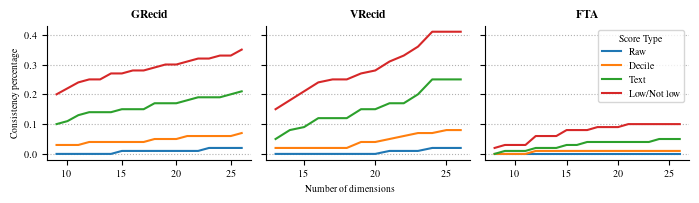

In [120]:
# Grouping and calculating the mean
grouped = statsdf.groupby(['score', 'st', 'i'])['cons'].mean().reset_index()

score_type_labels = {
    "rs" : "Raw",
    "ds" : "Decile",
    "txt" : "Text",
    "lnl" : "Low/Not low",
}

# Plotting
x_ticks = {
    "grecid" : [10, 15, 20, 25],
    "vrecid" : [15, 20, 25],
    "fta" : [10, 15, 20, 25],
}
fig, axes = plt.subplots(1, 3, figsize=(7, 2), sharey=True)
latex_titles = {"grecid": "$\\mathbf{GRecid}$", "vrecid": "$\\mathbf{VRecid}$", "fta": "$\\mathbf{FTA}$"}
for ax, score in zip(axes, scores):
    for score_type in score_types:
        subset = grouped[(grouped['score'] == score) & (grouped['st'] == score_type)]
        ax.plot(subset['i'], subset['cons'], label=score_type_labels[score_type])
    ax.set_title(latex_titles[score])
    ax.spines['top'].set_visible(False)  # Remove the top border
    ax.spines['right'].set_visible(False)  # Remove the right border
    ax.set_xlabel('')  # Remove individual x-axis labels
    ax.grid(True, axis='y', linestyle='dotted')  # Only horizontal dotted gridlines
    ax.grid(False, axis='x')  # Remove vertical gridlines
    ax.set_xticks(x_ticks[score])  # Set uniform y-axis tick markers

axes[0].set_ylabel('Consistency percentage')  # Add y-axis label to the leftmost plot
axes[-1].legend(title="Score Type")  # Add legend only to the rightmost plot

# Adding a shared x-axis label
fig.text(0.5, -0.01, 'Number of dimensions', ha='center')  # Adjusted position

# Save the plot as a PDF at a specified location
output_path = "cons_scores.pdf"
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to ensure space for the legend and labels
# plt.savefig(output_path, format="pdf", bbox_inches="tight")  # Ensure full figure is saved

plt.show()

### Compute the SLevel consistency scores

In [32]:
for st in SLEVEL:
    print(f"\n Computing SLevel consistency percentage for {st}.")

    # Restrict the df to the relevant subset of dimensions.
    D = SLEVEL[st] + ["slevel"]
    df = slevel[D]

    # Make a variable fact situation.
    x = {d : Const(f'x_{d}', sorts[d]) for d in D}

    # Initialize the case base for this subset.
    C = Cs["slevel"]

    # Compute its consistency percentage.
    s.push()
    s.add([f for Y in C for f in [upb(x, Y, D), lob(x, Y, D)]])
    cons = 0
    total = len(C)
    for X in tqdm(C):
        s.push()
        s.add(equal(x, X, D))
        cons += s.check() == sat
        s.pop()
    s.pop()

    print(f"The consistency percentage is {cons} / {total} = {round(cons / total, 2)}.")


 Computing SLevel consistency percentage for rs.


100%|██████████| 12510/12510 [00:25<00:00, 488.96it/s]


The consistency percentage is 10369 / 12510 = 0.83.

 Computing SLevel consistency percentage for ds.


100%|██████████| 12510/12510 [00:03<00:00, 3237.07it/s]

The consistency percentage is 12510 / 12510 = 1.0.
